In [1]:
%pylab inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import MNIST

Populating the interactive namespace from numpy and matplotlib


In [2]:
train = MNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

test = MNIST('./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

# Create DataLoader
dataloader_args = dict(shuffle=True, batch_size=16,num_workers=1, pin_memory=True)
train_loader = dataloader.DataLoader(train, **dataloader_args)
test_loader = dataloader.DataLoader(test, **dataloader_args)

In [36]:
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - Transformed Shape:', train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

C:\Users\46145\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - Transformed Shape: torch.Size([28, 60000, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def sigmoid_cond(x):
    return x*(1-x)
sigmoid_v = np.vectorize(sigmoid)
sigmoid_d = np.vectorize(sigmoid_cond)

In [4]:
def n2l(y):
    yc = [0]*10
    yc[y] = 1
    return yc

In [5]:
def celoss(pred, y):
    entropy = 0
    for i in range(len(y)):
        entropy -= y[i]*np.log(pred[i])
    return entropy

In [6]:
def inference(W1, W2, x_input):
    x = x_input.reshape(-1)
    h = W1.dot(x)
    sh = sigmoid_v(h)
    z = W2.dot(sh)
    y = np.exp(z)/sum(np.exp(z))
    return y

In [7]:
d = 28 * 28
d1 = 300

In [12]:
losses = []
losses0 = []
W1 = (np.random.rand(d1, d)-0.5)/28
W2 = (np.random.rand(10, d1)-0.5)/28
for epoch in range(15):
    for batch_idx, (data, target) in enumerate(train_loader):
        # Get Samples
        loss_list = []
        x_batch = data.numpy()
        y_batch = target.numpy()

        g1list = []
        g2list = []
        for m in range(len(x_batch)):
            yl = y_batch[m]
            grad1 = np.zeros((d1, d))
            grad2 = np.zeros((10, d1))
            #forward
            x = x_batch[m].reshape(-1)
            h = W1.dot(x)
            sh = sigmoid_v(h)
            gsh = sigmoid_d(sh)
            z = W2.dot(sh)
            y = np.exp(z)/sum(np.exp(z))

            #loss
            loss = -np.log(y[yl])
            yc = n2l(yl)
            loss_list.append(loss)
            #losses0.append(loss)

            #backpropagation
            gw2 = np.outer(y, sh) - np.outer(yc, sh)
            itn = (W2.transpose().dot(y) - W2[yl])*gsh
            gw1 = np.outer(itn, x)
            
            g1list.append(gw1)
            g2list.append(gw2)
            #print(g1list)
        W1 -= 0.001/16*np.add.reduce(g1list)
        W2 -= 0.001/16*np.add.reduce(g2list)
        avg_loss = sum(loss_list)/len(loss_list)
        #print(avg_loss)
        losses.append(avg_loss)
        
        if batch_idx % 100 == 1:
            print('\r Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, 
                batch_idx * len(data), 
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                avg_loss), 
                end='')
            
    print()

 Train Epoch: 0 [59216/60000 (99%)]	Loss: 2.297401
 Train Epoch: 1 [59216/60000 (99%)]	Loss: 2.265862
 Train Epoch: 2 [59216/60000 (99%)]	Loss: 2.159642
 Train Epoch: 3 [59216/60000 (99%)]	Loss: 2.101860
 Train Epoch: 4 [59216/60000 (99%)]	Loss: 1.898080
 Train Epoch: 5 [59216/60000 (99%)]	Loss: 1.540202
 Train Epoch: 6 [59216/60000 (99%)]	Loss: 1.318016
 Train Epoch: 7 [59216/60000 (99%)]	Loss: 1.318964
 Train Epoch: 8 [59216/60000 (99%)]	Loss: 1.122175
 Train Epoch: 9 [59216/60000 (99%)]	Loss: 0.853958
 Train Epoch: 10 [59216/60000 (99%)]	Loss: 0.879154
 Train Epoch: 11 [59216/60000 (99%)]	Loss: 0.738527
 Train Epoch: 12 [59216/60000 (99%)]	Loss: 0.721422
 Train Epoch: 13 [59216/60000 (99%)]	Loss: 0.838231
 Train Epoch: 14 [59216/60000 (99%)]	Loss: 0.390907


Text(0, 0.5, 'cross entropy loss')

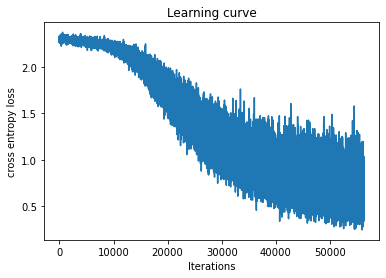

In [14]:
plt.plot(losses)

plt.title("Learning curve")
plt.xlabel("Iterations")
plt.ylabel("cross entropy loss")

In [15]:
evaluate_x = Variable(test_loader.dataset.test_data.type_as(torch.FloatTensor()))
evaluate_y = Variable(test_loader.dataset.test_labels)


C:\Users\46145\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
C:\Users\46145\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [16]:
count = 0
test_x = evaluate_x.numpy()
test_y = evaluate_y.numpy()
for i in range(len(test_x)):
    y_pred = inference(W1, W2, test_x[i])
    pred = np.argmax(y_pred)
    if test_y[i] == pred:
        count += 1
accuracy = count/len(test_x)
accuracy

<ipython-input-3-bee2fed0bf3a>:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


0.7983

In [18]:
for epoch in range(15,30):
    for batch_idx, (data, target) in enumerate(train_loader):
        # Get Samples
        loss_list = []
        x_batch = data.numpy()
        y_batch = target.numpy()

        g1list = []
        g2list = []
        for m in range(len(x_batch)):
            yl = y_batch[m]
            grad1 = np.zeros((d1, d))
            grad2 = np.zeros((10, d1))
            #forward
            x = x_batch[m].reshape(-1)
            h = W1.dot(x)
            sh = sigmoid_v(h)
            gsh = sigmoid_d(sh)
            z = W2.dot(sh)
            y = np.exp(z)/sum(np.exp(z))

            #loss
            loss = -np.log(y[yl])
            yc = n2l(yl)
            loss_list.append(loss)
            #losses0.append(loss)

            #backpropagation
            gw2 = np.outer(y, sh) - np.outer(yc, sh)
            itn = (W2.transpose().dot(y) - W2[yl])*gsh
            gw1 = np.outer(itn, x)
            
            g1list.append(gw1)
            g2list.append(gw2)
            #print(g1list)
        W1 -= 0.0001/16*np.add.reduce(g1list)
        W2 -= 0.0001/16*np.add.reduce(g2list)
        avg_loss = sum(loss_list)/len(loss_list)
        #print(avg_loss)
        losses.append(avg_loss)
        
        if batch_idx % 100 == 1:
            print('\r Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, 
                batch_idx * len(data), 
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                avg_loss), 
                end='')
            
    print()

 Train Epoch: 15 [59216/60000 (99%)]	Loss: 0.523165
 Train Epoch: 16 [59216/60000 (99%)]	Loss: 0.654530
 Train Epoch: 17 [59216/60000 (99%)]	Loss: 0.390712
 Train Epoch: 18 [59216/60000 (99%)]	Loss: 0.658601
 Train Epoch: 19 [59216/60000 (99%)]	Loss: 0.354551
 Train Epoch: 20 [59216/60000 (99%)]	Loss: 0.554946
 Train Epoch: 21 [59216/60000 (99%)]	Loss: 0.491406
 Train Epoch: 22 [59216/60000 (99%)]	Loss: 0.429852
 Train Epoch: 23 [59216/60000 (99%)]	Loss: 0.456510
 Train Epoch: 24 [59216/60000 (99%)]	Loss: 0.511683
 Train Epoch: 25 [59216/60000 (99%)]	Loss: 0.981498
 Train Epoch: 26 [59216/60000 (99%)]	Loss: 0.393872
 Train Epoch: 27 [59216/60000 (99%)]	Loss: 0.275075
 Train Epoch: 28 [59216/60000 (99%)]	Loss: 0.422048
 Train Epoch: 29 [59216/60000 (99%)]	Loss: 0.472818


Text(0, 0.5, 'cross entropy loss')

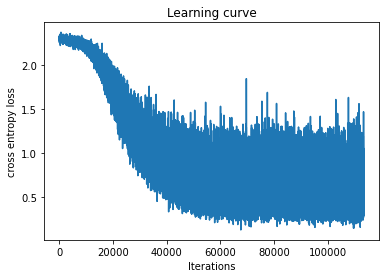

In [19]:
plt.plot(losses)

plt.title("Learning curve")
plt.xlabel("Iterations")
plt.ylabel("cross entropy loss")

In [20]:
count = 0
test_x = evaluate_x.numpy()
test_y = evaluate_y.numpy()
for i in range(len(test_x)):
    y_pred = inference(W1, W2, test_x[i])
    pred = np.argmax(y_pred)
    if test_y[i] == pred:
        count += 1
accuracy = count/len(test_x)
accuracy

<ipython-input-3-bee2fed0bf3a>:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


0.8124